# Homework 4

## References

+ Lectures 13-16 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [2]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

## Student details

+ **First Name: Ran**
+ **Last Name: An**
+ **Email:an141@purdue.edu**

# Problem 1 - Estimating the mechanical properties of a plastic material from molecular dynamics simulations

First, make sure that [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/stress_strain.txt) dataset is visible from this Jupyter notebook.
You may achieve this by either:

+ Downloading the data file, and then mannually upload it on Google Colab. The easiest way is to click on the folder icon on the left of the browser window and click on the upload button (or just drag and drop the file). Some other options are [here](https://colab.research.google.com/notebooks/io.ipynb).
+ Downloading the file to the working directory of this notebook with this code:

In [2]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/stress_strain.txt"
download(url)

It's up to you what you choose to do.
If the file is in the right place, the following code should work:

In [3]:
data =  np.loadtxt('stress_strain.txt')

The dataset was generated using a molecular dynamics simulation of a plastic material (thanks to [Professor Alejandro Strachan](https://engineering.purdue.edu/MSE/people/ptProfile?id=33239) for sharing the data!).
Specifically, Strachan's group did the following:
- They took a rectangular chunk of the material and marked the position of each one of its atoms;
- They started applying a tensile force along one dimension.
The atoms are coupled together through electromagnetic forces and they must all satisfy Newton's law of motion.
- For each value of the applied tensile force they marked the stress (force be unit area) in the middle of the materail and the corresponding strain of the material (percent enlogation in the pulling direction).
- Eventually the material entered the plastic regime and then it broke.
Here is a visualization of the data:

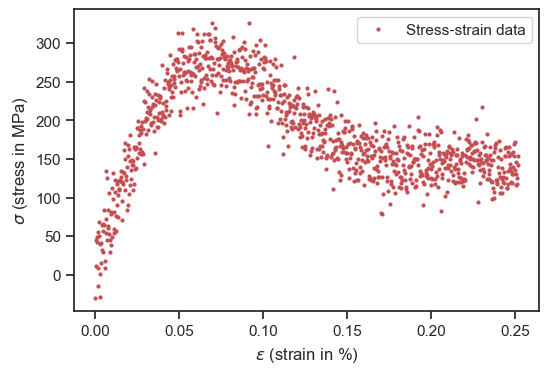

In [4]:
# Strain 
x = data[:, 0]
# Stress in MPa
y = data[:, 1]

plt.figure()
plt.plot(
    x,
    y,
    'ro',
    markersize=2,
    label='Stress-strain data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best');

Note that for each particular value of the strain, you don't necessarily get a unique stress.
This is because in molecular dynamics the atoms are jiggling around due to thermal effects.
So there is always this "jiggling" noise when you are trying to measure the stress and the strain.
We would like to process this noise in order to extract what is known as the [stress-strain curve](https://en.wikipedia.org/wiki/Stress–strain_curve) of the material.
The stress-strain curve is a macroscopic property of the the material which is affeted by the fine structure, e.g., the chemical bonds, the crystaline structure, any defects, etc.
It is a required input to mechanics of materials.

## Part A - Fitting the stress-strain curve in the elastic regime
The very first part of the stress-strain curve should be linear.
It is called the *elastic regime*.
In that region, say $\epsilon < \epsilon_l=0.04$, the relationship between stress and strain is:

$$
\sigma(\epsilon) = E\epsilon.
$$

The constant $E$ is known as the *Young modulus* of the material.
Assume that you measure $\epsilon$ without any noise, but your measured $\sigma$ is noisy.

### Subpart A.I
First, extract the relevant data for this problem, split it into training and validation datasets, and visualize the training and validation datasets using different colors.

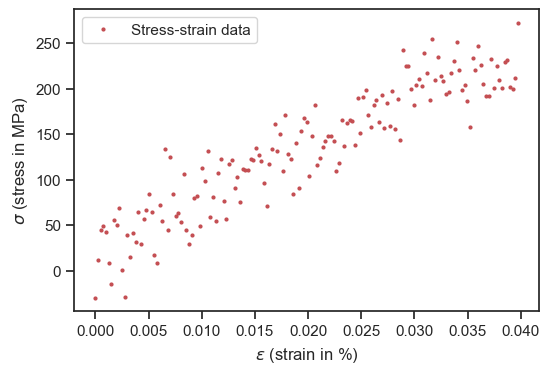

In [5]:
# The point at which the stress-strain curve stops being linear
epsilon_l = 0.04
# Relevant data (this is nice way to get the linear part of the stresses and straints)
x_rel = x[x < 0.04]
y_rel = y[x < 0.04]

# Visualize to make sure you have the right data
plt.figure()
plt.plot(
    x_rel,
    y_rel,
    'ro',
    markersize=2,
    label='Stress-strain data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best');

Split your data into training and validation.

**Hint:** You may use [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) if you wish.

In [6]:
# Split the data into training and validation datasets
# Hint: Consult the lecture notes
from sklearn.model_selection import train_test_split

# Split data into train partition and validation partition
x_train, x_valid, y_train, y_valid = train_test_split(x_rel, y_rel, test_size=0.33)

Use the following to visualize your split:

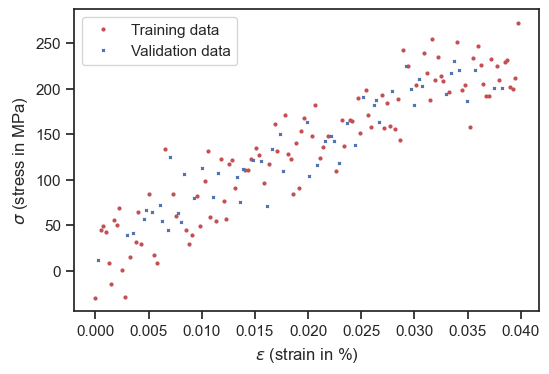

In [7]:
plt.figure()
plt.plot(
    x_train,
    y_train,
    'ro',
    markersize=2,
    label='Training data'
)
plt.plot(
    x_valid,
    y_valid,
    'bx',
    markersize=2,
    label='Validation data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best');

### Subpart A.II
Perform Bayesian linear regression with the evidence approximation to estimate the noise variance and the hyperparameters of the prior.

the relationship between stress and strain is:

$$
\sigma(\epsilon) = E\epsilon.
$$

**hyper-parameters** of the model $\theta$:

$$
\boldsymbol{\theta} = \{\sigma, \alpha, \ell,\dots\}.
$$
The maximum a posteriori estimate for $\boldsymbol{\theta}$:

$$
\boldsymbol{\theta}_{\mbox{EV}} = \arg\max_{\boldsymbol{\theta}}\int p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}|\mathbf{w},\boldsymbol{\theta})p(\mathbf{w}|\boldsymbol{\theta})d\mathbf{w}.
$$

Using the *evidence approximation* for the hyper-parameters.

In [9]:
from sklearn.linear_model import BayesianRidge
# Solve the least squares problem
num_obs = x_train.shape[0]
Phi = x_train.reshape((num_obs, 1)) # reshape the input to 2D array
# Fit
model = BayesianRidge(
    fit_intercept=False,
).fit(Phi, y_train)

In [12]:
sigma = np.sqrt(1.0 / model.alpha_)
print(f'noise variance = {sigma**2}')
print('sigma = {0:1.2f}'.format(sigma))
alpha = model.lambda_
print(f'alpha = {alpha}')
print(f'l = 1')
# The posterior mean of the weights is here (this is for the normalized features, however)
w = model.coef_
print(f"Posterior mean w: {w[0]}")
S = model.sigma_
print(f"Posterior covariance w:")
print(S)

noise variance = 967.8781277806809
sigma = 31.11
alpha = 2.430090492157894e-08
l = 1
Posterior mean w: 6413.604830834413
Posterior covariance w:
[[16486.315]]


### Subpart A.III
Calculate the mean square error of the validation data.

$N_t$ test data points with inputs $x_{t,i}$ and outputs $y_{t,i}$, the the MSE of your model is given by the formula:

$$
\text{MSE} = \frac{\sum_{i=1}^{N_t}\left[y_{t,i} - \mathbf{w}^T\boldsymbol{\phi}(x_{t,i})\right]^2}{N_t}.
$$


In [13]:
Phi_valid = x_valid.reshape((x_valid.shape[0], 1)) # reshape the input to 2D array
y_predict, y_std = model.predict(
    Phi_valid,
    return_std=True
)
MSE_valid = np.linalg.norm(y_predict - y_valid)
print(f'MSE of the validation data is {MSE_valid}')

MSE of the validation data is 191.2066109169729


### Subpart A.IV
Make the observations vs predictions plot for the validation data.

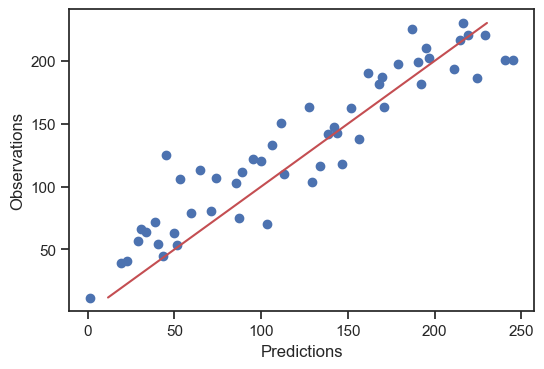

In [14]:
fig, ax = plt.subplots()
ax.plot(y_predict, y_valid, 'o')
yys = np.linspace(
    y_valid.min(),
    y_valid.max(),
    100)
ax.plot(yys, yys, 'r-')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

### Subpart A.V
Compute and plot the standarized errors for the validation data.

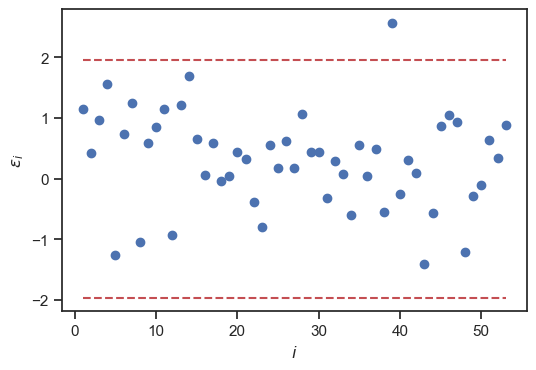

In [15]:
eps = (y_valid - y_predict) / y_std
idx = np.arange(1, eps.shape[0] + 1)

fig, ax = plt.subplots()
ax.plot(idx, eps, 'o', label='Standarized errors')
ax.plot(idx, 1.96 * np.ones(eps.shape[0]), 'r--')
ax.plot(idx, -1.96 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$');

### Subpart A.VI
Make the quantile-quantile plot of the standarized errors.

This compares the empirical quantiles of the standarized errors:


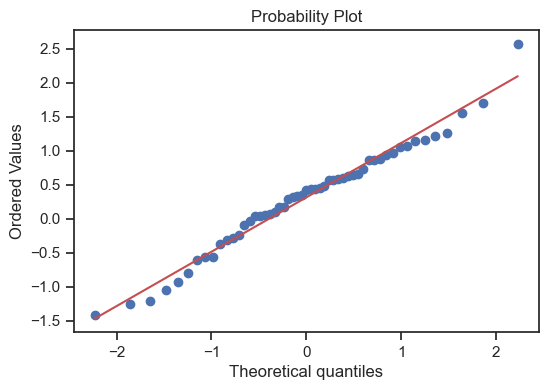

In [16]:
print("This compares the empirical quantiles of the standarized errors:")
fig, ax = plt.subplots()
st.probplot(eps, dist=st.norm, plot=ax);

### Subpart A.VII
Visualize your epistemic and the aleatory uncertainty about the stress-strain curve in the elastic regime.

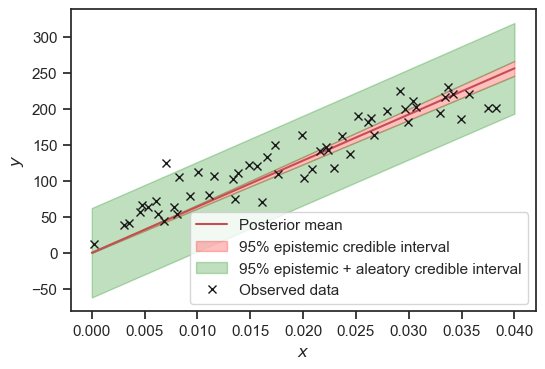

In [17]:
xx = np.linspace(0, 0.04, 100)
yy_mean, yy_measured_std = model.predict(
    xx.reshape((xx.shape[0], 1)),
    return_std=True
)
sigma = np.sqrt(1.0 / model.alpha_)
yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
yy_le = yy_mean - 2.0 * yy_std
yy_ue = yy_mean + 2.0 * yy_std
yy_lae = yy_mean - 2.0 * yy_measured_std
yy_uae = yy_mean + 2.0 * yy_measured_std

fig, ax = plt.subplots()
ax.plot(xx, yy_mean, 'r', label="Posterior mean")
ax.fill_between(
    xx,
    yy_le,
    yy_ue,
    color='red',
    alpha=0.25,
    label="95% epistemic credible interval"
)
ax.fill_between(
    xx,
    yy_lae,
    yy_le,
    color='green',
    alpha=0.25
)
ax.fill_between(
    xx,
    yy_ue,
    yy_uae,
    color='green',
    alpha=0.25,
    label="95% epistemic + aleatory credible interval"
)
ax.plot(x_valid, y_valid, 'kx', label='Observed data')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc="best");



### Subpart A. VIII
Visualize the posterior of the Young modulus E conditioned on the data.

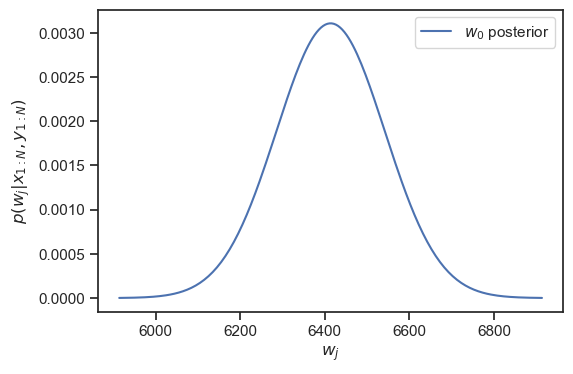

In [18]:
import scipy.stats as st
S = model.sigma_
ww = np.linspace(w[0]-500, w[0]+500, 200)

fig, ax = plt.subplots()
for j in range(S.shape[0]):
    wj_post = st.norm(
        loc=w[j],
        scale=np.sqrt(S[j, j])
    )
    ax.plot(
        ww,
        wj_post.pdf(ww),
        label=f'$w_{{{j}}}$ posterior')
ax.set_xlabel("$w_j$")
ax.set_ylabel(f'$p(w_j|x_{{1:N}}, y_{{1:N}})$')
plt.legend(loc='best');

### Subpart A.IX
Take five samples of stress-strain curve in the elastic regime and visualize them.

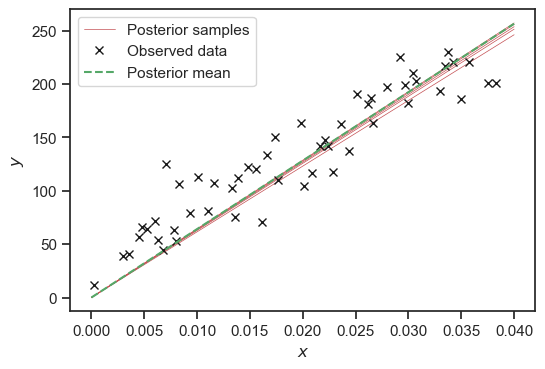

In [19]:
Phi_xx = xx.reshape((xx.shape[0], 1))
w_post = st.multivariate_normal(
    mean=w,
    cov=S + sigma**2 * np.eye(S.shape[0])
)
fig, ax = plt.subplots()
for _ in range(5):
    w_sample = w_post.rvs()
    yy_sample = Phi_xx * w_sample
    ax.plot(xx, yy_sample, 'r', lw=0.5)
ax.plot([], [], "r", lw=0.5, label="Posterior samples")
ax.plot(x_valid, y_valid, 'kx', label='Observed data')
ax.plot(xx, yy_mean, 'g--', label="Posterior mean")
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc="best");

### Subpart A.X

Find the 95% centered credible interval for the Young modulus $E$.

In [20]:
w_post = st.norm(
        loc=w[0],
        scale=np.sqrt(S[0, 0])
    )
w_low = w_post.ppf(0.025)
w_up = w_post.ppf(0.975)
print(f'w is in [{w_low:.2f}, {w_up:1.2f}] with 95% probability')

w is in [6161.95, 6665.26] with 95% probability


### Subpart A.XI
If you had to pick a single value for the Young modulus $E$, what would it be and why?

In [21]:
print(f'I will pick the mean w = {w[0]}')

I will pick the mean w = 6413.604830834413


because that has the highest $p(w|x_{{1:N}}, y_{{1:N}})$ using the evidence approxiamtion:
at the marginal posterior of $\boldsymbol{\theta}$:

$$
p(\mathbf{w}, \boldsymbol{\theta}|\mathbf{x}_{1:n}, \mathbf{y}_{1:n}) \propto p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}|\mathbf{w},\boldsymbol{\theta})p(\mathbf{w}|\boldsymbol{\theta})p(\boldsymbol{\theta}).
$$

and, a maximum a posteriori estimate for $\boldsymbol{\theta}$:

$$
\boldsymbol{\theta}_{\mbox{EV}} = \arg\max_{\boldsymbol{\theta}}\int p(\mathbf{y}_{1:n}|\mathbf{x}_{1:n}|\mathbf{w},\boldsymbol{\theta})p(\mathbf{w}|\boldsymbol{\theta})d\mathbf{w}.
$$
Assume that the hyper-prior is relatively flat:

$$
p(\boldsymbol{\theta}) \propto 1.
$$
Then, the mean w is the optimal solution for the Young modulus $E$

## Part B - Estimate the ultimate strength

The pick of the stress-strain curve is known as the ultimate strength.
We will like to estimate it.

### Subpart B.I - Extract training and validation data

Extract training and validation data from the entire dataset.

In [22]:
# your code here - Repeat as many text and code blocks as you like
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33)

Use the following to visualize your split:

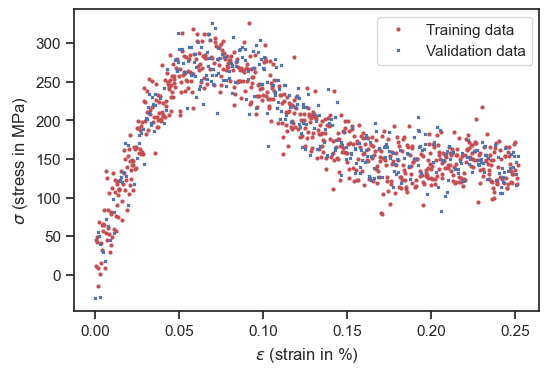

In [23]:
plt.figure()
plt.plot(
    x_train,
    y_train,
    'ro',
    markersize=2,
    label='Training data'
)
plt.plot(
    x_valid,
    y_valid,
    'bx',
    markersize=2,
    label='Validation data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best');

### Subpart B.II - Model the entire stress-strain relationship.
To do this, we will set up a generalized linear model that can capture the entire stress-strain relationship.
Remember, you can use any model you want as soon as:
+ it is linear in the parameters to be estimated,
+ it clearly has a well-defined elastic regime (see Part A).

I am going to help you set up the right model.
We are goint to use the [Heavide step function](https://en.wikipedia.org/wiki/Heaviside_step_function) to turn on or off models for various ranges of $\epsilon$. The idea is quite simple: We will use a linear model for the elastic regime and we are going to turn to a non-linear model for the non-linear regime.
Here is a model that has the right form in the elastic regime and an arbitrary form in the non-linear regime:

$$
f(\epsilon;E,\mathbf{w}_g) = E\epsilon \left[(1 - H(\epsilon - \epsilon_l)\right] + g(\epsilon;\mathbf{w}_g)H(\epsilon - \epsilon_l),
$$

where

$$
H(x) = \begin{cases}
0,\;\text{if}\;x < 0\\
1,\;\text{otherwise},
\end{cases}
$$

and $g$ is any function linear in the parameters $\mathbf{w}_g$.

You can use any model you like for the non-linear regime, but let's use a polynomial of degree $d$:

$$
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i.
$$

The full model can be expressed as:

$$
\begin{split}
f(\epsilon) &= 
\begin{cases}
h(\epsilon) = E \epsilon,\ \epsilon < \epsilon_l, \\
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i, \epsilon \geq \epsilon_l
\end{cases}\\
&= E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
\end{split}
$$

We could proceed with this model, but there is a small problem: It is discontinuous at $\epsilon = \epsilon_l$.
This is unphysical. We can do better than that!

To make the model nice, we force the $h$ and $g$ to match up to the first derivative, i.e., we demand that:

$$
\begin{split}
h(\epsilon_l) &= g(\epsilon_l)\\
h'(\epsilon_l) &= g'(\epsilon_l).
\end{split}
$$

The reason we include the first derivative is so that we don't have a kink in the stress-strain. That would also be unphysical.
The two equations above become:

$$
\begin{split}
E\epsilon_l &= \sum_{i=0}^dw_i\epsilon_l^i\\
E &= \sum_{i=1}^diw_i\epsilon_l^{i-1}.
\end{split}
$$

We can use these two equations to eliminate two weights.
Let's eliminate $w_0$ and $w_1$.
All you have to do is express them in terms of $E$ and $w_2,\dots,w_d$.
So, there remain $d$ parameters to estimate.
Let's get back to the stress-strain model.

Our stress-strain model was:

$$
f(\epsilon) = E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
$$

We can now use the expressions for $w_0$ and $w_1$ to rewrite this using only all the other 
parameters.
I am going to spare you the details...
The end result is:

$$
f(\epsilon) = E\epsilon + \sum_{i=2}^dw_i\left[(i-1)\epsilon_{l}^{i} - i \epsilon \epsilon_{l}^{i-1} + \epsilon^i\right]H(\epsilon - \epsilon_l).
$$

Okay.
This is still a generalized linear model. This is nice.
Write code for the design matrix:

In [24]:
# Complete this code to make your model:
def compute_design_matrix(Epsilon, epsilon_l, d):
    """Compute the design matrix for the stress-strain curve problem.
    
    Arguments:
        Epsilon     -     A 1D array of dimension N.
        epsilon_l   -     The strain signifying the end of the elastic regime.
        d           -     The polynomial degree.
    
    Returns:
        A design matrix N x d
    """
    # Sanity check
    assert isinstance(Epsilon, np.ndarray)
    assert Epsilon.ndim == 1, 'Pass the array as epsilon.flatten(), if it is two dimensional'
    n = Epsilon.shape[0]
    # The design matrix:
    Phi = np.ndarray((n, d))
    # The step function evaluated at all the elements of Epsilon.
    # You can use it if you want.
    Step = np.ones(n)
    Step[Epsilon < epsilon_l] = 0
    # Build the design matrix
    Phi[:, 0] = Epsilon # Your code here
    for i in range(2, d+1):
        Phi[:, i-1] = ((i-1)*epsilon_l**i - (i*epsilon_l**(i-1))*Epsilon + Epsilon**i)*Step # Your code here
    return Phi

Visualize the basis functions here:

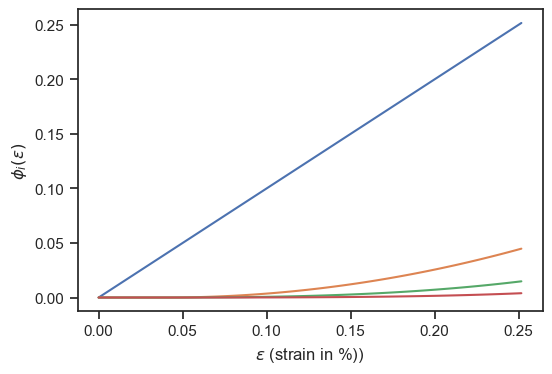

In [25]:
d = 4
eps = np.linspace(0, x.max(), 100)
Phis = compute_design_matrix(eps, epsilon_l, d)
fig, ax = plt.subplots(dpi=100)
ax.plot(eps, Phis)
ax.set_xlabel('$\epsilon$ (strain in %))')
ax.set_ylabel('$\phi_i(\epsilon)$');

### Subpart B.III 

Fit the model using automatic relevance determination and demonstrate that it works well by doing all the things we did above (MSE, observations vs predictions plot, standarized errors, etc.).

In [26]:
# Your code here - Use as many blocks as you need!
from sklearn.linear_model import BayesianRidge
Phi = compute_design_matrix(x_train, epsilon_l, d)
# Fit
model = BayesianRidge(
    fit_intercept=False
).fit(Phi, y_train)

In [28]:
sigma = np.sqrt(1.0 / model.alpha_)
print(f'noise variance = {sigma**2}')
print('sigma = {0:1.2f}'.format(sigma))
alpha = model.lambda_
print(f'alpha = {alpha}')
print(f'l = 4')
# The posterior mean of the weights is here (this is for the normalized features, however)
w = model.coef_
print(f"Posterior mean w: {w[0]}")

noise variance = 720.5424681323979
sigma = 26.84
alpha = 8.55206799992147e-13
l = 4
Posterior mean w: 5447.786347805481


### Subpart B-A.III
Calculate the mean square error of the validation data.$$
\text{MSE} = \frac{\sum_{i=1}^{N_t}\left[y_{t,i} - \mathbf{w}^T\boldsymbol{\phi}(x_{t,i})\right]^2}{N_t}.
$$

In [29]:
Phi_valid = compute_design_matrix(x_valid, epsilon_l, d) # reshape the input to 2D array
y_predict, y_std = model.predict(
    Phi_valid,
    return_std=True
)
MSE_valid = np.linalg.norm(y_predict - y_valid)
print(f'MSE of the validation data is {MSE_valid}')

MSE of the validation data is 489.6768774013578


### Subpart B-A.IV
Make the observations vs predictions plot for the validation data.

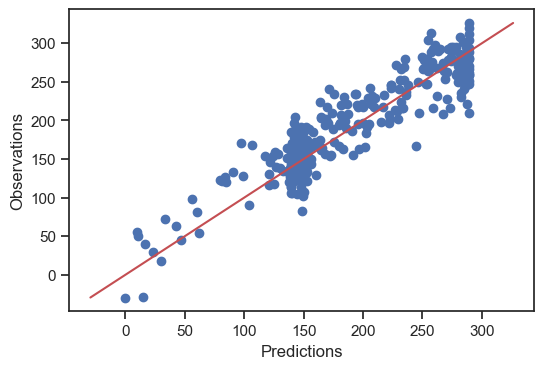

In [30]:
fig, ax = plt.subplots()
ax.plot(y_predict, y_valid, 'o')
yys = np.linspace(
    y_valid.min(),
    y_valid.max(),
    100)
ax.plot(yys, yys, 'r-')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

### Subpart B-A.V
Compute and plot the standarized errors for the validation data.

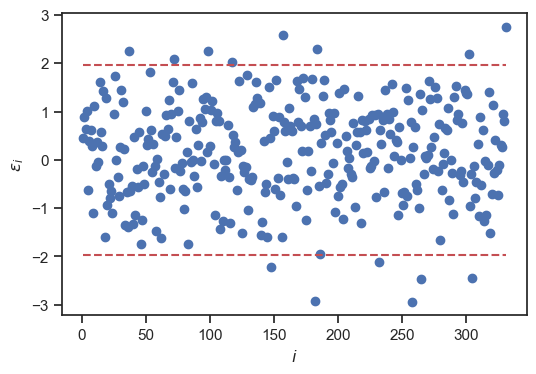

In [31]:
eps = (y_valid - y_predict) / y_std
idx = np.arange(1, eps.shape[0] + 1)

fig, ax = plt.subplots()
ax.plot(idx, eps, 'o', label='Standarized errors')
ax.plot(idx, 1.96 * np.ones(eps.shape[0]), 'r--')
ax.plot(idx, -1.96 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$');

### Subpart B-A.VI
Make the quantile-quantile plot of the standarized errors.

This compares the empirical quantiles of the standarized errors:


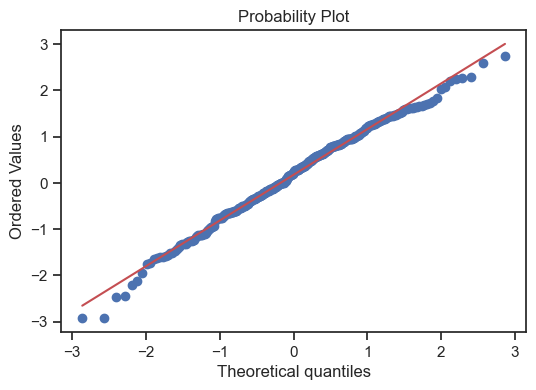

In [32]:
print("This compares the empirical quantiles of the standarized errors:")
fig, ax = plt.subplots()
st.probplot(eps, dist=st.norm, plot=ax);

### Subpart B.IV
Visualize epistemic and aleatory uncertainty in the stess-strain relation.

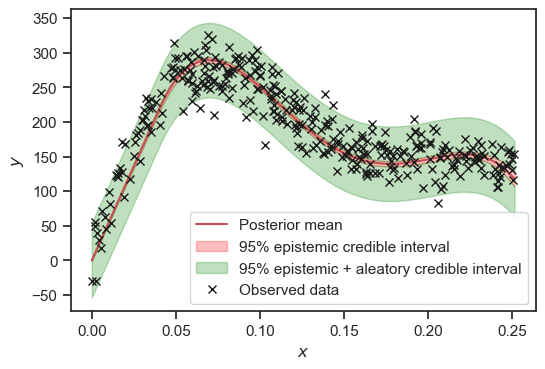

In [33]:
xx = np.linspace(0, x.max(), 100)
yy_mean, yy_measured_std = model.predict(
    compute_design_matrix(xx, epsilon_l, d),
    return_std=True
)
sigma = np.sqrt(1.0 / model.alpha_)
yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
yy_le = yy_mean - 2.0 * yy_std
yy_ue = yy_mean + 2.0 * yy_std
yy_lae = yy_mean - 2.0 * yy_measured_std
yy_uae = yy_mean + 2.0 * yy_measured_std

fig, ax = plt.subplots()
ax.plot(xx, yy_mean, 'r', label="Posterior mean")
ax.fill_between(
    xx,
    yy_le,
    yy_ue,
    color='red',
    alpha=0.25,
    label="95% epistemic credible interval"
)
ax.fill_between(
    xx,
    yy_lae,
    yy_le,
    color='green',
    alpha=0.25
)
ax.fill_between(
    xx,
    yy_ue,
    yy_uae,
    color='green',
    alpha=0.25,
    label="95% epistemic + aleatory credible interval"
)
ax.plot(x_valid, y_valid, 'kx', label='Observed data')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc="best");

### Subpart B.V - Extract the ultimate strength

Now, you are going to quantify your epistemic uncertainty about the ultimate strength.
The ultimate strength is the maximum of the stress-strain relationship.
Since you have epistemic uncertainty about the stress-strain relationship, you also have epistemic uncertainty about the ultimate strength.

Do the following:
- Visualize posterior of the ultimate strength.
- Find a 95% credible interval for the ultimate strength.
- Pick a value for the ultimate strength.

**Hint:**
To characterize your epistemic uncertainty about the ultimate strength, you would have to do the following:
- Define a dense set of strain points between 0 and 0.25.
- Repeatedly:
    + sample from the posterior of the weights of your model
    + for each sample evaluate the stresses at the dense set of strain points defined earlier
    + for each sampled stress vector, find the maximum. This is a sample of the ultimate strength.

In [34]:
num_peak_stresses = 5000
xx = np.linspace(0, 0.25, 1000)
yy_max = np.ndarray((num_peak_stresses,))
Phi_xx = compute_design_matrix(xx, epsilon_l, d)
w_post = st.multivariate_normal(
    mean=w,
    cov= model.sigma_ + sigma**2 * np.eye(S.shape[0])
)
for i in range(num_peak_stresses):
    w_sample = w_post.rvs()
    yy_sample = Phi_xx @ w_sample
    yy_max[i] = max(yy_sample)

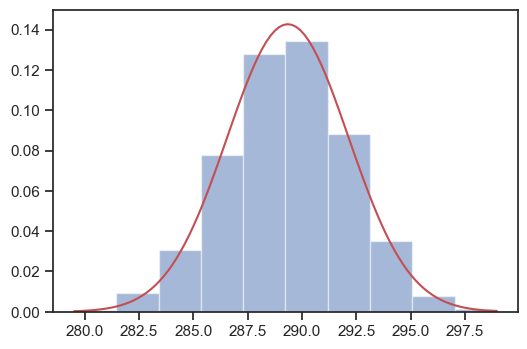

In [35]:
fig, ax = plt.subplots()
ax.hist(yy_max, alpha=0.5, density=True)
yy = np.linspace(yy_max.min(), yy_max.max(), 100)
ax.plot(yy, st.norm(np.mean(yy_max), np.std(yy_max)).pdf(yy), 'r');

In [36]:
w_low = st.norm(np.mean(yy_max), np.std(yy_max)).ppf(0.025)
w_up = st.norm(np.mean(yy_max), np.std(yy_max)).ppf(0.975)
print(f'max stress is in [{w_low:.2f}, {w_up:1.2f}] with 95% probability')

max stress is in [283.87, 294.83] with 95% probability


The ultimate strength is the mean because it has the highest probability.

In [37]:
print(f'the ultimate strength is {np.mean(yy_max)}')

the ultimate strength is 289.34881670845465


# Problem 2 - Optimizing the performance of a compressor

In this problem we are going to need [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/compressor_data.xlsx) dataset. The dataset was kindly provided to us by [Professor Davide Ziviani](https://scholar.google.com/citations?user=gPdAtg0AAAAJ&hl=en).
As before, you can either put it on your Google drive or just download it with the code segment below:

In [38]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/compressor_data.xlsx"
download(url)

Note that this is an Excell file, so we are going to need pandas to read it.
Here is how:

In [39]:
import pandas as pd
data = pd.read_excel('compressor_data.xlsx')
data

,T_e,DT_sh,T_c,DT_sc,T_amb,f,m_dot,m_dot.1,Capacity,Power,Current,COP,Efficiency
0,-30,11,25,8,35,60,28.8,8.000000,1557,901,4.4,1.73,0.467
1,-30,11,30,8,35,60,23.0,6.388889,1201,881,4.0,1.36,0.425
2,-30,11,35,8,35,60,17.9,4.972222,892,858,3.7,1.04,0.382
3,-25,11,25,8,35,60,46.4,12.888889,2509,1125,5.3,2.23,0.548
4,-25,11,30,8,35,60,40.2,11.166667,2098,1122,5.1,1.87,0.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,10,11,45,8,35,60,245.2,68.111111,12057,2525,11.3,4.78,0.722
61,10,11,50,8,35,60,234.1,65.027778,10939,2740,12.3,3.99,0.719
62,10,11,55,8,35,60,222.2,61.722222,9819,2929,13.1,3.35,0.709
63,10,11,60,8,35,60,209.3,58.138889,8697,3091,13.7,2.81,0.693


The data are part of a an experimental study of a variable speed reciprocating compressor.
The experimentalists varied two temperatures $T_e$ and $T_c$ (both in C) and they measured various other quantities.
Our goal is to learn the map between $T_e$ and $T_c$ and measured Capacity and Power (both in W).
First, let's see how you can extract only the relevant data.

In [40]:
# Here is how to extract the T_e and T_c columns and put them in a single numpy array
x = data[['T_e','T_c']].values
x

array([[-30,  25],
       [-30,  30],
       [-30,  35],
       [-25,  25],
       [-25,  30],
       [-25,  35],
       [-25,  40],
       [-25,  45],
       [-20,  25],
       [-20,  30],
       [-20,  35],
       [-20,  40],
       [-20,  45],
       [-20,  50],
       [-15,  25],
       [-15,  30],
       [-15,  35],
       [-15,  40],
       [-15,  45],
       [-15,  50],
       [-15,  55],
       [-10,  25],
       [-10,  30],
       [-10,  35],
       [-10,  40],
       [-10,  45],
       [-10,  50],
       [-10,  55],
       [-10,  60],
       [ -5,  25],
       [ -5,  30],
       [ -5,  35],
       [ -5,  40],
       [ -5,  45],
       [ -5,  50],
       [ -5,  55],
       [ -5,  60],
       [ -5,  65],
       [  0,  25],
       [  0,  30],
       [  0,  35],
       [  0,  40],
       [  0,  45],
       [  0,  50],
       [  0,  55],
       [  0,  60],
       [  0,  65],
       [  5,  25],
       [  5,  30],
       [  5,  35],
       [  5,  40],
       [  5,  45],
       [  5,

In [41]:
# Here is how to extract the Capacity
y = data['Capacity'].values
y

array([ 1557,  1201,   892,  2509,  2098,  1726,  1398,  1112,  3684,
        3206,  2762,  2354,  1981,  1647,  5100,  4547,  4019,  3520,
        3050,  2612,  2206,  6777,  6137,  5516,  4915,  4338,  3784,
        3256,  2755,  8734,  7996,  7271,  6559,  5863,  5184,  4524,
        3883,  3264, 10989, 10144,  9304,  8471,  7646,  6831,  6027,
        5237,  4461, 13562, 12599, 11633, 10668,  9704,  8743,  7786,
        6835,  5891, 16472, 15380, 14279, 13171, 12057, 10939,  9819,
        8697,  7575], dtype=int64)

Fit the following multivariate polynomial model to **both the Capacity and the Power**:

$$
y = w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2 + w_6T_c^2 + w_7 T_e^2T_c + w_8T_eT_c^2 + w_9 T_e^3 + w_{10}T_c^3 + \epsilon,
$$

where $\epsilon$ is a Gaussian noise term with unknown variance.

**Hints:**
+ You may use [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to construct the design matrix of your polynomial features. Do not program the design matrix by hand.
+ You should split your data into training and validation and use various validation metrics to make sure that your models make sense.
+ Use [ARD Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html#sklearn.linear_model.ARDRegression) to fit any hyperparameters and the noise.

### Subpart A.I - Fit the capacity

Please don't just fit blindly. Split in training and test and use all the usual diagnostics.

In [42]:
# Split the data into training and validation datasets
# Hint: Consult the lecture notes
from sklearn.model_selection import train_test_split

# Split data into train partition and validation partition
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33)

In [43]:
from sklearn.preprocessing import PolynomialFeatures
def compute_design_matrix(x, d):
    """Compute the design matrix for the stress-strain curve problem.
    
    Arguments:
        x     -     A 1D array of dimension N.
        d           -     The polynomial degree.
    
    Returns:
        A design matrix
    """
    # Sanity check
    assert isinstance(x, np.ndarray)
    return PolynomialFeatures(d).fit_transform(x)

In [44]:
d = 3
Phi = compute_design_matrix(x_train, d)
Phi.shape

(43, 10)

In [45]:
from sklearn.linear_model import ARDRegression
# Fit
model = ARDRegression(
    fit_intercept=False,
    threshold_lambda=np.inf
).fit(Phi, y_train)
sigma = np.sqrt(1.0 / model.alpha_)
print(f'sigma = {sigma}')
alpha = model.lambda_
print(f'alpha = {alpha}')
# The posterior mean of the weights is here (this is for the normalized features, however)
w = model.coef_
print(f"Posterior mean w: {w}")
S = model.sigma_
print(f"Posterior covariance w:")
print(S)

sigma = 0.31110044311028706
alpha = [4.306e-09 3.036e-06 3.489e-05 1.827e-02 1.137e-01 1.523e+02 1.555e+03
 5.709e+02 1.255e+03 1.595e+05]
Posterior mean w: [ 1.524e+04  5.740e+02 -1.693e+02  7.399e+00 -2.965e+00 -8.088e-02
  2.532e-02 -4.183e-02 -2.820e-02  2.066e-03]
Posterior covariance w:
[[ 8.085e+00  5.660e-02 -5.977e-01 -8.776e-04 -3.366e-03  1.407e-02
  -1.162e-05  1.218e-05  4.656e-05 -1.055e-04]
 [ 5.660e-02  7.952e-03 -4.692e-03  1.393e-04 -3.831e-04  1.174e-04
   3.366e-07 -3.669e-06  4.279e-06 -9.001e-07]
 [-5.977e-01 -4.692e-03  4.482e-02  3.096e-05  2.740e-04 -1.067e-03
   5.281e-07 -2.014e-07 -3.744e-06  8.074e-06]
 [-8.776e-04  1.393e-04  3.096e-05  6.723e-06 -6.282e-06 -2.950e-07
   7.707e-08 -1.344e-07  6.336e-08  6.371e-10]
 [-3.366e-03 -3.831e-04  2.740e-04 -6.282e-06  1.896e-05 -6.822e-06
  -1.681e-08  1.703e-07 -2.163e-07  5.237e-08]
 [ 1.407e-02  1.174e-04 -1.067e-03 -2.950e-07 -6.822e-06  2.567e-05
  -1.009e-08 -5.931e-09  9.306e-08 -1.957e-07]
 [-1.162e-05  3.

#### Subpart A.III
Calculate the mean square error of the validation data.$$
\text{MSE} = \frac{\sum_{i=1}^{N_t}\left[y_{t,i} - \mathbf{w}^T\boldsymbol{\phi}(x_{t,i})\right]^2}{N_t}.
$$

In [46]:
Phi_valid = compute_design_matrix(x_valid, d) # reshape the input to 2D array
y_predict, y_std = model.predict(
    Phi_valid,
    return_std=True
)
MSE_valid = np.linalg.norm(y_predict - y_valid)
print(f'MSE of the validation data is {MSE_valid}')

MSE of the validation data is 1.7831373832667083


#### Subpart A.IV
Make the observations vs predictions plot for the validation data.

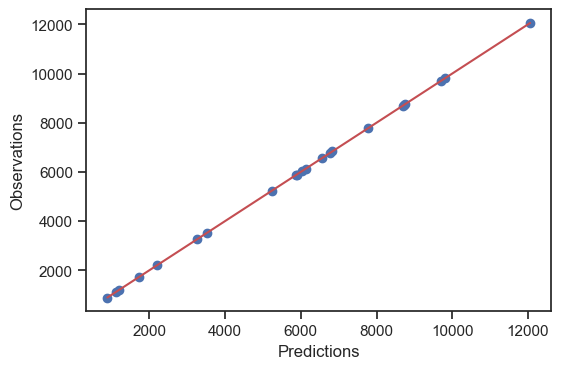

In [47]:
fig, ax = plt.subplots()
ax.plot(y_predict, y_valid, 'o')
yys = np.linspace(
    y_valid.min(),
    y_valid.max(),
    100)
ax.plot(yys, yys, 'r-')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

#### Subpart A.V
Compute and plot the standarized errors for the validation data.

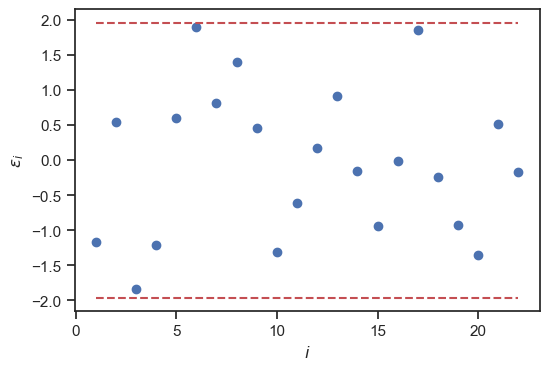

In [48]:
eps = (y_valid - y_predict) / y_std
idx = np.arange(1, eps.shape[0] + 1)

fig, ax = plt.subplots()
ax.plot(idx, eps, 'o', label='Standarized errors')
ax.plot(idx, 1.96 * np.ones(eps.shape[0]), 'r--')
ax.plot(idx, -1.96 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$');

#### Subpart A.VI
Make the quantile-quantile plot of the standarized errors.

This compares the empirical quantiles of the standarized errors:


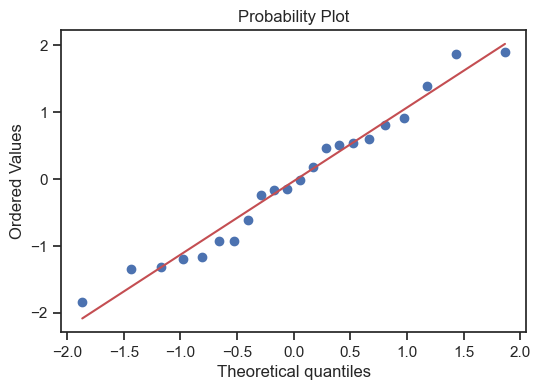

In [49]:
print("This compares the empirical quantiles of the standarized errors:")
fig, ax = plt.subplots()
st.probplot(eps, dist=st.norm, plot=ax);

### Subpart A.II

What is the noise variance you estimated for the Capacity?

In [50]:
sigma = np.sqrt(1.0 / model.alpha_)
print(f'noise variance = {sigma**2}')

noise variance = 0.09678348570341695


### Subpart A.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Capacity?

The most important for predicting the Capacity is the w1


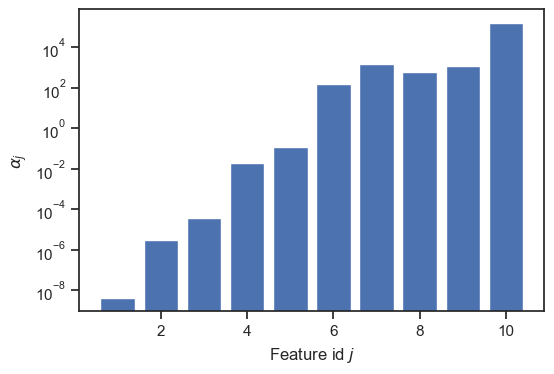

In [51]:
alpha = model.lambda_
print("The most important for predicting the Capacity is the w1")

fig, ax = plt.subplots()
ax.bar(np.arange(1, 11), alpha)
ax.set_xlabel('Feature id $j$')
ax.set_ylabel(r'$\alpha_j$')
ax.set_yscale("log")

### Subpart B.I - Fit the Power

Please don't just fit blindly. Split in training and test and use all the usual diagnostics.

In [52]:
y = data['Power'].values
# Split data into train partition and validation partition
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33)

In [53]:
Phi = compute_design_matrix(x_train, d)
# Fit
model = ARDRegression(
    fit_intercept=False,
    threshold_lambda=np.inf
).fit(Phi, y_train)
sigma = np.sqrt(1.0 / model.alpha_)
print(f'sigma = {sigma}')
alpha = model.lambda_
print(f'alpha = {alpha}')
# The posterior mean of the weights is here (this is for the normalized features, however)
w = model.coef_
print(f"Posterior mean w: {w}")
S = model.sigma_
print(f"Posterior covariance w:")
print(S)

sigma = 0.296394814494719
alpha = [2.773e-06 2.311e-04 4.711e-04 2.294e-01 1.533e-01 1.464e+02 7.169e+03
 1.412e+03 1.645e+04 1.304e+05]
Posterior mean w: [ 6.005e+02 -6.579e+01  4.607e+01 -2.088e+00  2.554e+00 -8.253e-02
 -1.173e-02  2.657e-02 -7.668e-03 -2.381e-03]
Posterior covariance w:
[[ 6.511e+00  5.031e-02 -4.768e-01 -5.011e-04 -2.706e-03  1.107e-02
  -1.402e-05  2.213e-06  3.367e-05 -8.180e-05]
 [ 5.031e-02  6.261e-03 -3.924e-03  1.103e-04 -2.996e-04  9.293e-05
   4.735e-07 -2.828e-06  3.280e-06 -6.776e-07]
 [-4.768e-01 -3.924e-03  3.541e-02  1.135e-05  2.098e-04 -8.310e-04
   7.605e-07  3.237e-07 -2.600e-06  6.189e-06]
 [-5.011e-04  1.103e-04  1.135e-05  5.334e-06 -4.905e-06  3.667e-08
   5.690e-08 -1.042e-07  4.901e-08 -1.182e-09]
 [-2.706e-03 -2.996e-04  2.098e-04 -4.905e-06  1.475e-05 -4.971e-06
  -2.266e-08  1.297e-07 -1.649e-07  3.643e-08]
 [ 1.107e-02  9.293e-05 -8.310e-04  3.667e-08 -4.971e-06  1.969e-05
  -1.555e-08 -1.426e-08  6.180e-08 -1.478e-07]
 [-1.402e-05  4.73

#### Subpart A.III
Calculate the mean square error of the validation data.

In [54]:
Phi_valid = compute_design_matrix(x_valid, d) # reshape the input to 2D array
y_predict, y_std = model.predict(
    Phi_valid,
    return_std=True
)
MSE_valid = np.linalg.norm(y_predict - y_valid)
print(f'MSE of the validation data is {MSE_valid}')

MSE of the validation data is 1.439827665923844


#### Subpart A.IV
Make the observations vs predictions plot for the validation data.

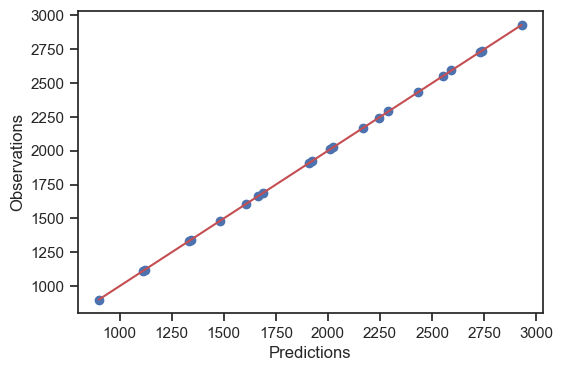

In [55]:
fig, ax = plt.subplots()
ax.plot(y_predict, y_valid, 'o')
yys = np.linspace(
    y_valid.min(),
    y_valid.max(),
    100)
ax.plot(yys, yys, 'r-')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

#### Subpart A.V
Compute and plot the standarized errors for the validation data.

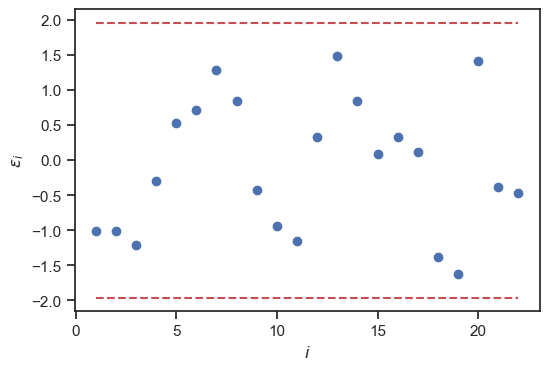

In [56]:
eps = (y_valid - y_predict) / y_std
idx = np.arange(1, eps.shape[0] + 1)

fig, ax = plt.subplots()
ax.plot(idx, eps, 'o', label='Standarized errors')
ax.plot(idx, 1.96 * np.ones(eps.shape[0]), 'r--')
ax.plot(idx, -1.96 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$');

#### Subpart A.VI
Make the quantile-quantile plot of the standarized errors.

This compares the empirical quantiles of the standarized errors:


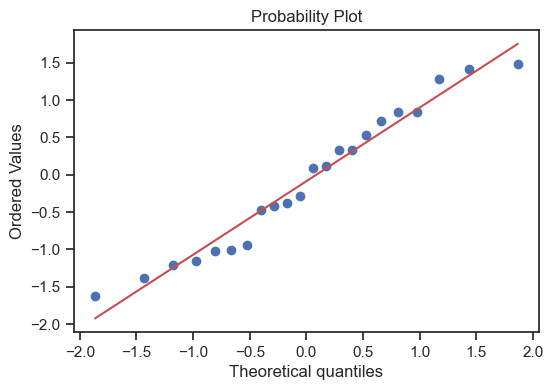

In [57]:
print("This compares the empirical quantiles of the standarized errors:")
fig, ax = plt.subplots()
st.probplot(eps, dist=st.norm, plot=ax);

### Subpart B.II

What is the noise variance you estimated for the Power?

In [58]:
sigma = np.sqrt(1.0 / model.alpha_)
print(f'noise variance = {sigma**2}')

noise variance = 0.08784988605935888


### Subpart B.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Power?

The most important for predicting the Capacity is the w1


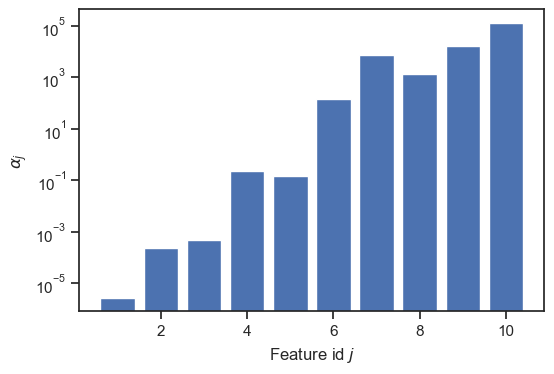

In [59]:
alpha = model.lambda_
print("The most important for predicting the Capacity is the w1")

fig, ax = plt.subplots()
ax.bar(np.arange(1, 11), alpha)
ax.set_xlabel('Feature id $j$')
ax.set_ylabel(r'$\alpha_j$')
ax.set_yscale("log")

# Problem 3 - Explaining the challenger disaster
On January 28, 1986, the [Space Shuttle Challenger](https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster) disintegrated after 73 seconds from launch.
The failure can be traced on the rubber O-rings which were used to seal the joints of the solid rocket boosters (required to force the hot, high-pressure gases generated by the burning solid propelant through the nozzles thus producing thrust).

It turns out that the performance of the O-ring material was particularly sensitive on the external temperature during launch.
This [dataset](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/challenger_data.csv) contains records of different experiments with O-rings recorded at various times between 1981 and 1986.
Download the data the usual way (either put them on Google drive or run the code cell below).

In [16]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/challenger_data.csv"
download(url)

Even though this is a csv file, you should load it with pandas because it contains some special characters.

In [17]:
import pandas as pd
raw_data = pd.read_csv('challenger_data.csv')
raw_data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,6/27/82,80,NaN
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1


The first column is the date of the record. The second column is the external temperature of that day in degrees F.
The third column labeled ``Damage Incident`` is has a binary coding (0=no damage, 1=damage).
The very last row is the day of the Challenger accident.

We are going to use the first 23 rows to solve a binary classification problem that will give us the probability of an accident conditioned on the observed external temperature in degrees F. Before we proceed to the analysis of the data, let's clean the data up.

First, we drop all the bad records:

In [18]:
clean_data_0 = raw_data.dropna()
clean_data_0

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


We also don't need the last record. Just remember that the temperature the day of the Challenger accident was 31 degrees F.

In [19]:
clean_data = clean_data_0[:-1]
clean_data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


Let's extract the features and the labels:

In [20]:
x = clean_data['Temperature'].values
x

array([66, 70, 69, 68, 67, 72, 73, 70, 57, 63, 70, 78, 67, 53, 67, 75, 70,
       81, 76, 79, 75, 76, 58], dtype=int64)

In [21]:
y = clean_data['Damage Incident'].values.astype(np.float)
y

C:\Users\aanrr\AppData\Local\Temp\ipykernel_15268\1039112519.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = clean_data['Damage Incident'].values.astype(np.float)


array([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1.])

## Part A - Perform logistic regression

Perform logistic regression between the temperature ($x$) and the damage label ($y$).
Do not bother doing a validation because there are not a lot of data.
Just use a very simple model so that you don't overfit.

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

# Design matrix
poly = PolynomialFeatures(1)
Phi = poly.fit_transform(x[:, None])

# Fit
model = LogisticRegression(
    penalty='none',
    fit_intercept=False
).fit(Phi, y)

## Part B - Plot the probability of damage as a function of temperature
Plot the probability of damage as a function of temperature.

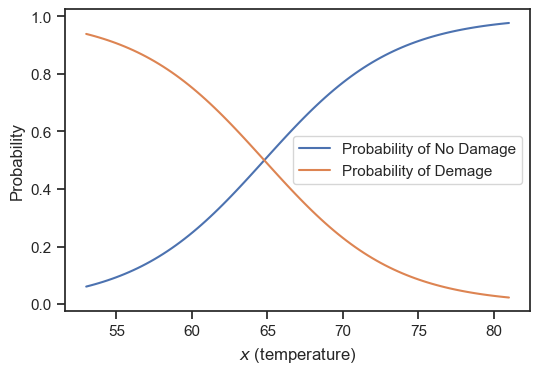

In [23]:
fig, ax = plt.subplots()
xx = np.linspace(x.min(), x.max(), 100)
Phi_xx = poly.fit_transform(xx[:, None])
predictions_xx = model.predict_proba(Phi_xx)
ax.plot(
    xx,
    predictions_xx[:, 0],
    label='Probability of No Damage'
)
ax.plot(
    xx,
    predictions_xx[:, 1],
    label='Probability of Demage'
)
ax.set_xlabel('$x$ (temperature)')
ax.set_ylabel('Probability')
plt.legend(loc='best');

## Part C - Decide whether or not to launch

The temperature the day of the Challenger accident was 31 degrees F.
Start by calculating the probability of damage at 31 degrees F.
Then, use formal decision-making (i.e., define a cost matrix and make decisions by minimizing the expected loss) to decide whether or not to launch on that day.
Also, plot your optimal decision as a function of the external temperature.

Make probabilistic predictions on the validation data:

In [24]:
x_valid = np.array([31])
y_valid = np.array(['accident'])
Phi_valid = poly.fit_transform(x_valid[:, None])
predictions = model.predict_proba(Phi_valid)
print('x\tp(y=0|x)\tp(y=1|x)\tTrue label')
print('-' * 80)
for i in range(x_valid.shape[0]):
    print(
        f"{x_valid[i]:1.2f}\t"
        + f"{predictions[i, 0]:1.5f}\t\t"
        + f"{predictions[i, 1]:1.5f}\t\t"
        + f"accident"
    )

x	p(y=0|x)	p(y=1|x)	True label
--------------------------------------------------------------------------------
31.00	0.00039		0.99961		accident


Pose and solve the decision-making problem by first define a cost matrix:

In [25]:
# c_00 = cost of correctly picking 0 when 0 is true
# c_01 = cost of wrongly picking 0 when 1 is true
# c_11 = cost of correctly picking 1 when 1 is true
# c_10 = cost of wrongly picking 1 when 0 is true
cost_matrix = np.array(
    [
        [0.0, 2.0],
        [1.0, 0.0]
    ]
)

Plot the decision boundary of our model:

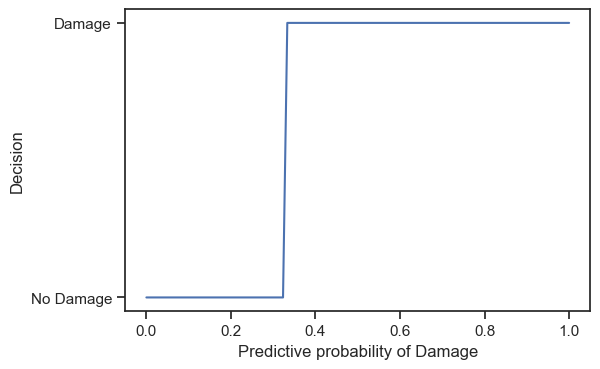

In [26]:
fig, ax = plt.subplots()
pE = np.linspace(0, 1, 100)
pN = 1.0 - pE
probs = np.hstack([pN[:, None], pE[:, None]])
exp_cost = np.einsum('ij,kj->ki', cost_matrix, probs)
decision_idx = np.argmin(exp_cost, axis=1)
ax.plot(pE, decision_idx)
ax.set_yticks([0, 1])
ax.set_yticklabels(['No Damage', 'Damage'])
ax.set_ylabel('Decision')
ax.set_xlabel('Predictive probability of Damage');

Computes the expected cost of each choice given the predicted probabilities:

In [27]:
def expected_cost(cost_matrix, prediction_prob):
    """Calculate the expected cost of each decision.
    
    Arguments
    cost_matrix     --  A D x D matrix. `cost_matrix[i, j]`
                        is the cost of picking `i` and then
                        `j` happens.
    prediction_prob --  An array with D elements containing
                        the probability that each event
                        happens.
    """
    assert cost_matrix.ndim == 2
    D = cost_matrix.shape[0]
    assert cost_matrix.shape[1] == D
    assert prediction_prob.ndim == 1
    assert prediction_prob.shape[0] == D
    res = np.zeros((2,))
    for i in range(2):
        res[i] = (
            cost_matrix[i, 0] * prediction_prob[0]
            + cost_matrix[i, 1] * prediction_prob[1]
        )
    return res

print('x\tCost of 0\t\t\tCost of 1\t\t\tTrue label\t\tChoice')
print('-' * 100)
for i in range(x_valid.shape[0]):
    exp_c = expected_cost(cost_matrix, predictions[i])
    line = f'{x_valid[i]}\t{exp_c[0]}'
    tmp = f'\t\t{exp_c[1]}'
    correct_choice = True
    if exp_c[0] < exp_c[1]:
        line += '*'
        if y_valid[i] == 1:
            correct_choice = False
    else:
        tmp += '*'
        if y_valid[i] == 0:
            correct_choice = False
    line += tmp + f'\t\t{y_valid[i]}'
    if correct_choice:
        line += '\t\tCORRECT'
    else:
        line += '\t\tWRONG'
    print(line)

x	Cost of 0			Cost of 1			True label		Choice
----------------------------------------------------------------------------------------------------
31	1.9992175656767277		0.00039121716163614817*		accident		CORRECT


Visualize these probabilities:

[[1.999e+00 3.912e-04]]


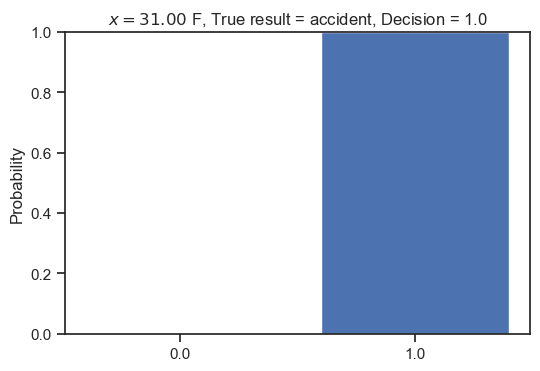

In [28]:
exp_cost = np.einsum('ij,kj->ki', cost_matrix, predictions)
print(exp_cost)
for i in range(x_valid.shape[0]):
    # Make decision
    decision = model.classes_[np.argmin(exp_cost[i])]
    fig, ax = plt.subplots()
    ax.bar(np.arange(2), predictions[i])
    ax.set_title(
        f'$x={x_valid[i]:1.2f}$ F, '
        + f'True result = {y_valid[i]}, '
        + f'Decision = {decision}'
    )
    ax.set_ylim([0, 1.0])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(model.classes_)
    ax.set_ylabel('Probability');